# Draw Nipoppy layout tree diagram

In [15]:
COLOUR_INIT = "#fac71066"
COLOUR_USER_CONFIG = "#8fd14f66"
COLOUR_PIPELINE_CONFIG = "#0ca78966"
COLOUR_STATUS = "#9610ad66"
COLOUR_DERIVATIVES = "#ff000066"

# nested list (kind of) where items are tuples: (name, colour, sublist)
# - if the entry is a file, sublist should be None
# - otherwise it is a (possibly empty) list with the same tuple structure
# - if colour is None, there will be no line or box drawn (only text label drawn)
FILE_TREE_SPEC = [
    (
        "<DATASET_ROOT>",
        COLOUR_INIT,
        [
            ("global_config.json", COLOUR_USER_CONFIG, None),
            ("manifest.tsv", COLOUR_USER_CONFIG, None),
            (
                "pipelines",
                COLOUR_INIT,
                [
                    (
                        "bidsification",
                        COLOUR_INIT,
                        [
                            ("dcm2bids-3.2.0", COLOUR_PIPELINE_CONFIG, []),
                        ],
                    ),
                    (
                        "processing",
                        COLOUR_INIT,
                        [
                            ("fmriprep-23.1.3", COLOUR_PIPELINE_CONFIG, []),
                            ("fmriprep-24.1.1", COLOUR_PIPELINE_CONFIG, []),
                        ],
                    ),
                    ("extraction", COLOUR_INIT, []),
                ],
            ),
            ("containers", COLOUR_INIT, []),
            (
                "sourcedata",
                COLOUR_INIT,
                [
                    ("tabular", COLOUR_INIT, []),
                    (
                        "imaging",
                        COLOUR_INIT,
                        [
                            ("pre-reorg", COLOUR_INIT, []),
                            ("post-reorg", COLOUR_INIT, []),
                            # ("curation_status.tsv", COLOUR_STATUS, None),
                        ],
                    ),
                ],
            ),
            (
                "tabular",
                COLOUR_INIT,
                [
                    # ("assessments", COLOUR_INIT, []),
                    # ("demographics.tsv", COLOUR_USER_TABULAR, None),
                    # ("tabular_status.tsv", COLOUR_STATUS, None),
                ],
            ),
            ("bids", COLOUR_INIT, []),
            (
                "derivatives",
                COLOUR_INIT,
                [
                    (
                        "fmriprep",
                        COLOUR_DERIVATIVES,
                        [
                            (
                                "23.1.3",
                                COLOUR_DERIVATIVES,
                                [
                                    ("output", COLOUR_DERIVATIVES, []),
                                    ("idp", COLOUR_DERIVATIVES, []),
                                ],
                            ),
                            ("24.1.1", COLOUR_DERIVATIVES, []),
                        ],
                    ),
                    # ("...", None, []),
                    ("processing_status.tsv", COLOUR_STATUS, None),
                ],
            ),
            ("code", COLOUR_INIT, []),
            ("logs", COLOUR_INIT, []),
            ("scratch", COLOUR_INIT, []),
        ],
    )
]

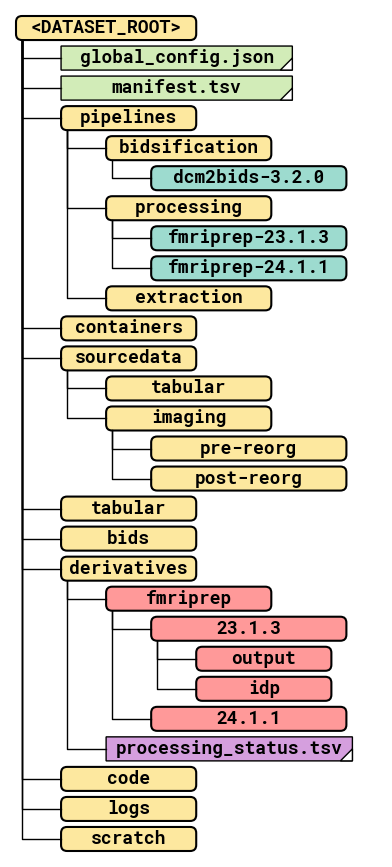

In [16]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyfonts import load_google_font

ROW_HEIGHT = 0.8
COL_WIDTH = 1.5
BOX_WIDTHS_DIR = [6, 4.5, 5.5, 6.5, 4.5]
BOX_WIDTHS_FILE = [0, 7.7, 8.2, 7.5, 0]
LINE_OFFSET = 0.2

COLOUR_OUTLINE = "#000000"
COLOUR_TRIANGLE = "#ffffff"

LINEWIDTH_DIR = 1.5
LINEWIDTH_FILE = 1
LINEWIDTH_LINE = 1

LABEL_FONTSIZE = 13
LABEL_FONT = load_google_font("Roboto Mono", weight="bold")


def _get_n_rows(spec: list):
    n_rows = 0
    for item in spec:
        n_rows += 1
        _, _, sublist = item
        if sublist:
            n_rows += _get_n_rows(sublist)
    return n_rows


def _get_n_cols(spec: list):
    n_col_candidates = []
    for item in spec:
        _, _, sublist = item
        if sublist:
            n_cols = 1 + _get_n_cols(sublist)
        else:
            n_cols = 1
        n_col_candidates.append(n_cols)
    return max(n_col_candidates)


def _draw_file(ax: plt.Axes, i_row, i_col, name, colour, is_directory=True, alpha=None):
    if is_directory:
        box_widths = BOX_WIDTHS_DIR
        linewidth = LINEWIDTH_DIR
        boxstyle = "round, pad=0, rounding_size=0.2"
    else:
        box_widths = BOX_WIDTHS_FILE
        linewidth = LINEWIDTH_FILE
        boxstyle = "round, pad=0, rounding_size=0"

    x_text = i_col * COL_WIDTH + box_widths[i_col] / 2
    y_text = i_row + ROW_HEIGHT / 2

    if box_widths[i_col] == 0:
        raise ValueError(
            f"Box width for column {i_col} is zero, cannot draw file '{name}'."
        )

    # draw the rectangle
    rectangle = patches.FancyBboxPatch(
        (i_col * COL_WIDTH, i_row),
        width=box_widths[i_col],
        height=ROW_HEIGHT,
        boxstyle=boxstyle,
        facecolor=colour,
        linewidth=linewidth,
        edgecolor=COLOUR_OUTLINE,
        alpha=alpha if colour is not None else 0,
    )
    ax.add_patch(rectangle)

    if not is_directory:
        x0 = i_col * COL_WIDTH + box_widths[i_col]  # right
        x1 = i_col * COL_WIDTH + box_widths[i_col] - ROW_HEIGHT / 2  # left
        y0 = i_row + ROW_HEIGHT / 2  # top
        y1 = i_row + ROW_HEIGHT  # bottom
        triangle = patches.Polygon(
            [[x0, y0], [x1, y1], [x0, y1]],
            facecolor=COLOUR_TRIANGLE,
            edgecolor=COLOUR_OUTLINE,
            linewidth=LINEWIDTH_FILE,
            alpha=alpha if colour is not None else 0,
        )
        ax.add_patch(triangle)

    # add text label
    ax.text(
        x_text,
        y_text,
        name,
        color=COLOUR_OUTLINE,
        font=LABEL_FONT,
        ha="center",
        va="center",
        fontsize=LABEL_FONTSIZE,
        alpha=alpha,
    )


def _draw_line(
    ax: plt.Axes, i_row_start, i_col_start, i_row_end, i_col_end, alpha=None
):
    x_start = i_col_start * COL_WIDTH + LINE_OFFSET
    x_end = i_col_end * COL_WIDTH
    y_start = i_row_start + ROW_HEIGHT
    y_end = i_row_end + ROW_HEIGHT / 2
    ax.plot(
        [x_start, x_start, x_end],
        [y_start, y_end, y_end],
        color=COLOUR_OUTLINE,
        linewidth=LINEWIDTH_LINE,
        alpha=alpha,
        zorder=-1,
    )


def draw_file_tree(spec, to_hide=None):
    def _draw_file_tree(spec, i_row, i_col, parent_i_row=None, parent_alpha=None):
        for name, color, sublist in spec:
            if to_hide and name in to_hide:
                alpha = 0
            else:
                alpha = parent_alpha

            is_directory = sublist is not None
            _draw_file(
                ax, i_row, i_col, name, color, is_directory=is_directory, alpha=alpha
            )
            if parent_i_row is not None:
                _draw_line(
                    ax,
                    parent_i_row,
                    i_col - 1,
                    i_row,
                    i_col,
                    alpha=alpha if color else 0,
                )

            i_row += 1

            if sublist:
                i_row = _draw_file_tree(
                    sublist,
                    i_row,
                    i_col + 1,
                    parent_i_row=i_row - 1,
                    parent_alpha=alpha,
                )

        return i_row

    n_rows = _get_n_rows(spec)
    n_cols = _get_n_cols(spec)

    if n_cols != len(BOX_WIDTHS_DIR) or n_cols != len(BOX_WIDTHS_FILE):
        raise ValueError(
            f"BOX_WIDTHS_DIR and BOX_WIDTHS_FILE must have {n_cols} elements, "
            f"got {len(BOX_WIDTHS_DIR)} and {len(BOX_WIDTHS_FILE)} respectively."
        )

    fig, ax = plt.subplots(figsize=(10, 11))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    x_min, x_max = 0, max(
        [
            i_col * COL_WIDTH + box_width
            for i_col, box_width in enumerate(BOX_WIDTHS_DIR)
        ]
        + [
            i_col * COL_WIDTH + box_width
            for i_col, box_width in enumerate(BOX_WIDTHS_FILE)
        ]
    )
    pad = 1 - ROW_HEIGHT
    y_min, y_max = 0, n_rows
    ax.set_xlim(x_min - pad, x_max + pad)
    ax.set_ylim(y_max, y_min - pad)

    _draw_file_tree(spec, 0, 0)

    ax.set_aspect("equal")
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig


fig = draw_file_tree(FILE_TREE_SPEC)

In [17]:
to_hide = {
    "global_config.json",
    "manifest.tsv",
    "demographics.tsv",
    # "curation_status.tsv",
    "dcm2bids-3.2.0",
    "fmriprep-23.1.3",
    "fmriprep-24.1.1",
    "fmriprep",
    "idp",
    "processing_status.tsv",
}

stop_hiding_list = [
    set(),
    {
        "global_config.json",
        "manifest.tsv",
        "demographics.tsv",
    },
    {
        "dcm2bids-3.2.0",
        "fmriprep-23.1.3",
        "fmriprep-24.1.1",
    },
    # {"curation_status.tsv"},
    {"fmriprep"},
    {"processing_status.tsv"},
    {"idp"},
]

for i_step, stop_hiding in enumerate(stop_hiding_list):
    to_hide = to_hide - stop_hiding
    fig = draw_file_tree(FILE_TREE_SPEC, to_hide=to_hide)
    fig.savefig(
        f"nipoppy_layout-step{i_step+1}.png",
        bbox_inches="tight",
        dpi=600,
        pad_inches=0,
        transparent=False,
    )
    plt.close(fig)

if len(to_hide) != 0:
    raise ValueError(f"Not all directories/files have been plotted: {to_hide}")